## Crescimento de regiões
Obs: tentei implementar porém não consegui, acho q ocorreu um problema no limiar de diferença entre os pixels da imagem e seus vizinhos. 

In [34]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import os

#retorna os vizinhos de um ponto
def is_pixel_inside_image(pixel, img_shape):
    """
        Verifica se o pixel de entrada pertence a imagem
        Essa função é utilizada para encontrar o ponto mais escuro da imagem
        Arguments:
            pixel: np.array -- Coordenadas dos pixels
            img_shape: np.array -- Vetor com o tamanho da imagem
        Return:
            boolean -- True se o pixel pertence a imagem e False se ele não pertence
    """
    return 0<=pixel[0]<img_shape[0] and 0<=pixel[1]<img_shape[1]

def contorno_img_grow(point,img_shape):
    """
        Encontra os pixels vizinhos(pixels de contorno) do ponto de entrada. 
        Essa função é utilizada para o crescimento de regiões.
        Arguments:
            point: np.array -- Coordenadas do ponto
            img_shape: np.array -- Vetor com o tamanho da imagem
        Return:
            Contorno - np.array -- Lista com todos os vizinhos de um pixel
    """
    orientations = [(1,0),(0,1),(-1,0),(0,-1)]
    contorno = []
    for orient in orientations:
        neighbour = (point[0]+orient[0], point[1]+orient[1])
        if is_pixel_inside_image(neighbour, img_shape):
            contorno.append(neighbour)
        else:
            None
    return contorno
#vizinhos_point = contorno_img_grow(point,img_shape)

def value_vizinhos(vizinhos_point,image):
    """
        Função para obter os valores de itensidades dos vizinhos de um pixel
        Arguments:
            vizinhos_point: np.array -- Coordenadas com todos os pixels que devem ter seus valores calculados na média
            image: np.array -- Uma matriz NumPy que representa a imagem
        Return:
            values_vizinhos: np.array -- Valores de itensidades dos vizinhos de um pixel
    """
    values_vizinhos = []
    for vizinho  in vizinhos_point:
        values_vizinhos.append(image[vizinho])
    return values_vizinhos

def mean_vizinhos_dos_vizinhos(vizinhos_point,img_shape,image):
    """
        Calcula a média dos pixels vizinhos dos viznhos 
        Arguments:
            vizinhos_point: np.array -- Coordenadas com todos os pixels que devem ter seus valores calculados na média
            img_shape: np.array -- Vetor com o tamanho da imagem
        Return:
            float -- Média dos valores de itensidade dos pixels vizinhos dos vizinhos
    """
    values_vizinhos = []
    for vizinho in vizinhos_point:
        vizinho = contorno_img_grow(vizinho,img_shape)
        values_vizinhos.append(value_vizinhos(vizinho,image))
    print(values_vizinhos)
    return np.mean(values_vizinhos)

def cresce_regiao_grow(image_grow,contorno):
    """
        Função que cresce a região de interesse da imagem, pitando os pixels que vão crescer de branco
        Arguments:
            image_grow: np.array -- Uma matriz NumPy que representa a imagem
            contorno: np.array -- Um vetor com todas as coordenadas da imagem que devem ter aumentar sua região
        Return:
            image_grow: np.array -- Uma matriz NumPy que representa a imagem com o crescimento de regiões
    """
    for ponto in contorno:
        image_grow[ponto] = 255
    return image_grow

#valores_vizinhos = value_vizinhos(vizinhos_point,image)

def contorno_img(point,img_shape,len_kernel):
    """
        Encontra os pixels vizinhos(pixels de contorno) do ponto de entrada
        Arguments:
            point: np.array -- Coordenadas do ponto
            len_kernel: np.array -- tamanho do kernel de varredura
        Return:
            Contorno - np.array -- Lista com todos os vizinhos de um pixel
    """
    contorno = []
    for y in range(point[0],point[0]+len_kernel):
        for x in range(point[1],point[1]+len_kernel):
            if is_pixel_inside_image((y,x), img_shape):
                contorno.append((y,x))
            else:
                None
    return contorno

def mean_vizinhos(vizinhos_point,image):
    """
        Calcula a média dos pixels vizinhos com o intuito de encontrar o kernel que possua a média mais escura, para colocar como ponto inicial da imagem
        Arguments:
            vizinhos_point: np.array -- Coordenadas com todos os pixels que devem ter seus valores calculados na média
            image: np.array -- Uma matriz NumPy que representa a imagem
        Return:
            float -- Média dos valores de itensidade dos pixels vizinhos
    """
    values_vizinhos = []
    for vizinho  in vizinhos_point:
        if(image[vizinho] <= 20):
            return None
        values_vizinhos.append(image[vizinho])
    return np.mean(values_vizinhos)


def cresce_regiao(image_grow,contorno):
    """
        Essa função atribui a cor preto na região que foi considerada mais escura da imagem
        Arguments:
            image_grow: np.array -- Uma matriz NumPy que representa a imagem
            contorno: np.array -- Um vetor com todas as coordenadas que devem ser pintadas de preto
        Return:
            image_grow: np.array -- Uma matriz NumPy que representa a imagem com o ponto mais escuro pintado de preto
    """
    for ponto in contorno:
        image_grow[ponto] = 0
    return image_grow

def varredura_imagem(image,img_shape):
    """
        Essa função realiza uma varredura na imagem com o intuito de encontrar o ponto mais escuro da imagem
        Arguments:
            image: np.array -- Uma matriz NumPy que representa a imagem
            img_shape: np.array -- Vetor com o tamanho da imagem
        Return:
            dark_point: list -- Uma lista com a coordenada do ponto mais escuro da imagem
    """
    mean_kernel = 255
    contorno_mais_escuro = []

    for y in range(img_shape[0]):
        for x in range(img_shape[1]):
            vizinhos_point = contorno_img((y,x),img_shape,11)
            mean_kernel_vizinhos = mean_vizinhos(vizinhos_point,image.copy())
            if(mean_kernel_vizinhos==None):
                continue
            if(mean_kernel_vizinhos<=mean_kernel):
                mean_kernel = mean_kernel_vizinhos
                contorno_mais_escuro = vizinhos_point
                dark_point = (y,x)
    return dark_point

def growth(image_grow,vizinhos,img_shape,image,pontos_analizados,limiar):
    todos_vizinhos = []
    for ponto in vizinhos:
        if(ponto not in pontos_analizados):
            pontos_analizados.append(ponto)
            vizinhos_point = contorno_img_grow(ponto,img_shape)
            #valores_vizinhos = value_vizinhos(vizinhos_point,image)
            media_vizinhos = mean_vizinhos(vizinhos_point,image.copy())
            every_points = vizinhos_point.copy()
            every_points.append(ponto)
            valor_ponto = image[ponto]
            print(media_vizinhos)
            if(abs(valor_ponto-media_vizinhos)<limiar):
                image_grow = cresce_regiao_grow(image_grow,every_points)
                todos_vizinhos.extend(vizinhos_point)
    
    return todos_vizinhos,image_grow,pontos_analizados  



In [35]:
def open_img(image_path):
    """
            Funcao responsavel por carregar imagens de um diretorio
            Arguments:
              image_path: Caminho do diretorio das imagens
            Return:
              dataset: Vetor, onde cada posição possui uma imagem carregada do diretório
        """
    dataset = []
    #carrega as imagens do diretorio
    for i in glob.glob(image_path + '/*.png', recursive=True):
        dataset.append(cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB))
    for j in glob.glob(image_path + '/*.jpg', recursive=True):
        dataset.append(cv2.cvtColor(cv2.imread(j), cv2.COLOR_BGR2RGB))

    return dataset

def show(pos,image,title):
  plt.subplot(pos)
  plt.imshow(image)
  plt.title(title)
  plt.axis('off')

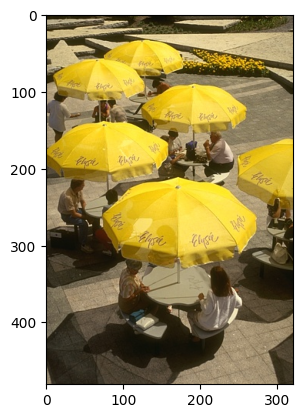

In [36]:
dataset = open_img('imagens')
image = dataset[0].copy()
plt.imshow(image,cmap='gray')

In [37]:
image = cv2.resize(image,(100,100))
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#plt.imshow(image,cmap='gray')

todos_vizinhos = [varredura_imagem(image.copy(),(100,100))]
img_shape = (100,100)
pontos_analizados = []
limiar = 1
#image_grow = np.ones((100,100))
image_grow = image.copy()
img = image.copy()
while(todos_vizinhos):
    todos_vizinhos,image_grow,pontos_analizados  =  growth(image_grow,todos_vizinhos,img_shape,img,pontos_analizados,limiar)

35.666666666666664


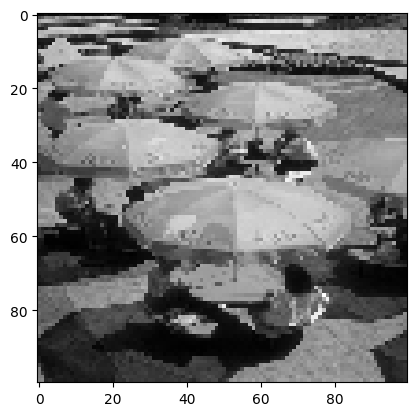

In [40]:
plt.imshow(image,cmap='gray')

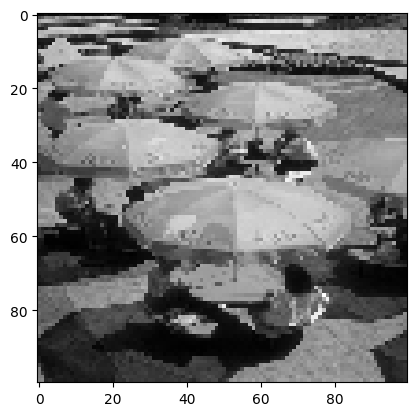

In [39]:
plt.imshow(image,cmap='gray')